#### Load Libraries and Define Functions

In [1]:
if True:
    from julia.api import Julia
    jl = Julia(compiled_modules=False)

import julia; julia.install(quiet=True)
from julia import Main

import numpy     as np

import plotly.graph_objects as go
from scipy.spatial.transform import Rotation as R

import param
import holoviews as hv; hv.extension("plotly", logo=False)
import panel as pn;     pn.extension("katex")

In [2]:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [3]:
%%julia
using Pkg; Pkg.activate("../GenLinAlgProblems")
using GenLinAlgProblems, LinearAlgebra, RowEchelon, Printf, Latexify, LaTeXStrings, Random, SymPy

  Activating project at `~/elementary-linear-algebra/GenLinAlgProblems`


In [4]:
%%julia
function principal_angles_form_basis_matrices(U::AbstractMatrix, V::AbstractMatrix)
    S = svd(U'V).S
    clamped = clamp.(S, -1, 1)
    return acosd.(clamped)
end;

In [5]:
%%html
<script src="https://cdnjs.cloudflare.com/ajax/libs/paper.js/0.12.18/paper-full.min.js"></script>

In [6]:
class Gr_1_2_Viewer(pn.viewable.Viewer, pn.custom.JSComponent):
    angle = param.Number(default=45, bounds=(0, 180), label="Angle (degrees)")

    _esm = """
    export function render({ model, el }) {
        const width  = 300;
        const height = 270;
        const xrange = [-1.5, 1.5];
        const yrange = [-0.3, 2.0];

        const canvas = document.createElement('canvas');
        canvas.width = width;
        canvas.height = height;
        canvas.style.border = "1px solid black";
        el.appendChild(canvas);

        const paperScope = new paper.PaperScope();
        paperScope.setup(canvas);

        const worldToScreen = (point) => {
            const x = (point.x - xrange[0]) / (xrange[1] - xrange[0]) * width;
            const y = height - (point.y - yrange[0]) / (yrange[1] - yrange[0]) * height;
            return new paperScope.Point(x, y);
        };

        function show_text(text, x, y, options = {}) {
            const point = worldToScreen({ x: x, y: y });

            const txt = new paperScope.PointText({
                point: point,
                content: text,
                fillColor: options.color || 'black',
                fontSize: options.fontSize || 16,
                justification: options.justification || 'left',
                fontFamily: options.fontFamily || 'monospace'
            });

            return txt;
        }

        function drawArrow(start, end, color, label, dashed = false, labelOffset = null) {
            const startPoint = worldToScreen(start);
            const endPoint = worldToScreen(end);

            const line = new paperScope.Path.Line({
                from: new paperScope.Point(startPoint.x, startPoint.y),
                to: new paperScope.Point(endPoint.x, endPoint.y),
                strokeColor: color,
                strokeWidth: 2,
                dashArray: dashed ? [5, 5] : null,
            });

            const arrowSize = 10;
            const direction = new paperScope.Point(endPoint.x - startPoint.x, endPoint.y - startPoint.y).normalize();

            const arrowHead = new paperScope.Path({
                segments: [
                    new paperScope.Point(endPoint.x, endPoint.y),
                    new paperScope.Point(
                        endPoint.x - direction.x * arrowSize + direction.y * arrowSize / 2,
                        endPoint.y - direction.y * arrowSize - direction.x * arrowSize / 2
                    ),
                    new paperScope.Point(
                        endPoint.x - direction.x * arrowSize - direction.y * arrowSize / 2,
                        endPoint.y - direction.y * arrowSize + direction.x * arrowSize / 2
                    )
                ],
                closed: true,
                fillColor: color,
            });

            if (label) {
                let labelPoint = new paperScope.Point(endPoint.x, endPoint.y);
                if (labelOffset) {
                    labelPoint = labelPoint.add(new paperScope.Point(labelOffset.x, labelOffset.y));
                } else {
                    const perp = new paperScope.Point(-direction.y, direction.x).normalize().multiply(15);
                    labelPoint = labelPoint.add(perp);
                }
                new paperScope.PointText({
                    point: labelPoint,
                    content: label,
                    fillColor: color,
                    fontSize: 12,
                    justification: 'center',
                });
            }
        }

        function redraw() {
            paperScope.project.clear();

            const origin = { x: 0, y: 0 };
            const angleRad = model.angle * Math.PI / 180;

            const u = { x: Math.cos(angleRad), y: Math.sin(angleRad) };
            const du = { x: -Math.sin(angleRad), y: Math.cos(angleRad) };

            // Draw the Grassmannian Gr(1,2) — semicircle of radius 1 from 0 to π
            const grPath = new paperScope.Path();
            for (let t = 0; t <= Math.PI; t += 0.01) {
                const x = Math.cos(t);
                const y = Math.sin(t);
                const pt = worldToScreen({ x: x, y: y });
                grPath.add(pt);
            }
            grPath.strokeColor = '#ddd';
            grPath.strokeWidth = 2;

            // Draw the full subspace line at angle θ through origin
            const len = 10;  // Extend both directions
            const start = { x: -u.x * len, y: -u.y * len };
            const end   = { x:  u.x * len, y:  u.y * len };

            new paperScope.Path.Line({
                from: worldToScreen(start),
                to: worldToScreen(end),
                strokeColor: '#444',
                strokeWidth: 1.5
            });

            // Draw unit vector u
            drawArrow(origin, u, 'blue', 'u(θ)');

            // Draw tangent vector du/dθ from tip of u
            const tip = { x: u.x + 0.4 * du.x, y: u.y + 0.4 * du.y };
            drawArrow(u, tip, 'red', "du/dθ", true);

            // Draw arc for angle θ
            const arcRadius = 0.3;
            const midAngle = angleRad / 2;
            const mid = {
                x: arcRadius * Math.cos(midAngle),
                y: arcRadius * Math.sin(midAngle)
            };
            new paperScope.Path.Arc({
                from: worldToScreen({ x: arcRadius, y: 0 }),
                through: worldToScreen(mid),
                to: worldToScreen({ x: arcRadius * Math.cos(angleRad), y: arcRadius * Math.sin(angleRad) }),
                strokeColor: 'black',
                strokeWidth: 2
            });

            // Add angle label
            const labelOffset = { x: 10, y: -10 };
            const labelPoint = worldToScreen(mid);
            new paperScope.PointText({
                point: labelPoint.add(new paperScope.Point(labelOffset.x, labelOffset.y)),
                content: `${model.angle.toFixed(1)}°`,
                fillColor: 'black',
                fontSize: 14,
                justification: 'center'
            });

            show_text( "Example: Gr(1,2)", -1.1, 1.8);
        }

        redraw();
        model.on("angle", () => redraw());
    }
    """

    def __init__(self, **params):
        super().__init__(**params)
        self.latex_pane = pn.pane.LaTeX(width=300, renderer='katex')
        self.slider = pn.widgets.FloatSlider.from_param(self.param.angle, width=300)
        self.param.watch(self._update_latex, 'angle')
        self._update_latex()

    def _update_latex(self, *_):
        angle_rad = np.radians(self.angle)
        c = np.cos(angle_rad)
        s = np.sin(angle_rad)
        #v = np.array([1.0, 0.0])
        #u = np.array([c, s])
        #dudt = np.array([-s, c])
        self.latex_pane.object = (
            "<div style='font-size:14px;font-family:monospace;'>"
            r"$\Large \begin{aligned}"
            rf"\theta &= {self.angle:.2f}^\circ \\"
            rf"u(\theta) &= \begin{{bmatrix}} {c:.2f} \\\\ {s:.2f} \end{{bmatrix}} \\"
            rf"\frac{{d u}}{{d \theta}} &= \begin{{bmatrix}} {-s:.2f} \\\\ {c:.2f} \end{{bmatrix}} \\"
            r"\end{aligned}$"
            "</span>"
        )

    def __panel__(self):
        return pn.Row(
            self,
            pn.Spacer(width=30),
            pn.Column(
                pn.Spacer(height=20),
                self.latex_pane,
                pn.Spacer(height=20),
                self.slider,
            )
        )

In [7]:
#%output backend="plotly"
def create_plane(origin, v1, v2, size=2.0):
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    points = [origin + a * v1 + b * v2 for a in [-size, size] for b in [-size, size]]
    x = np.array([p[0] for p in points]).reshape(2, 2)
    y = np.array([p[1] for p in points]).reshape(2, 2)
    z = np.array([p[2] for p in points]).reshape(2, 2)
    return x, y, z
def plot_vector_pair(u_vec, v_vec, scale=1.6, u_color='darkred', v_color='blue', name_prefix='principal'):
    return [
        go.Scatter3d(x=[0, u_vec[0]*scale], y=[0, u_vec[1]*scale], z=[0, u_vec[2]*scale],
                     mode='lines', line=dict(color=u_color, width=6), name=f'{name_prefix}_u'),
        go.Scatter3d(x=[0, v_vec[0]*scale], y=[0, v_vec[1]*scale], z=[0, v_vec[2]*scale],
                     mode='lines', line=dict(color=v_color, width=6), name=f'{name_prefix}_v')
    ]
def angle_arc(a, b, origin=np.zeros(3), steps=30, scale=1.6, color='green', name='Angle Arc'):
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    axis = np.cross(a, b)
    if np.linalg.norm(axis) < 1e-6:
        return None
    axis = axis / np.linalg.norm(axis)
    angle = np.arccos(np.clip(np.dot(a, b), -1.0, 1.0))
    pts = [R.from_rotvec(axis * t).apply(a) * scale for t in np.linspace(0, angle, steps)]
    pts = np.array(pts) + origin
    return go.Scatter3d(
        x=pts[:, 0], y=pts[:, 1], z=pts[:, 2],
        mode='lines', line=dict(color=color, width=4, dash='dot'),
        name=name
    )
def plot_intersection_line(u1, u2, v1, v2, scale=2.5):
    nU = np.cross(u1, u2)
    nV = np.cross(v1, v2)
    line_dir = np.cross(nU, nV)
    if np.linalg.norm(line_dir) < 1e-6:
        return None
    line_dir /= np.linalg.norm(line_dir)
    return go.Scatter3d(
        x=[-scale*line_dir[0], scale*line_dir[0]],
        y=[-scale*line_dir[1], scale*line_dir[1]],
        z=[-scale*line_dir[2], scale*line_dir[2]],
        mode='lines', line=dict(color='black', width=3, dash='dash'),
        name='Intersection Line'
    )

class Gr_2_3_Viewer(pn.viewable.Viewer):
    offset = param.Number(default=0.0,  bounds=(-5.0, 5.0), label="Z Offset for Plane V")
    theta_1 = param.Integer(default=0,  bounds=(-1800, 1800), label="theta_1")  # 10*degrees
    theta_2 = param.Integer(default=90, bounds=(-1800, 1800), label="theta_2")  # 10*degrees

    r     = param.Number(default=4.5, bounds=(1.0, 10.0), label="Camera Distance")
    theta = param.Number(default=45,  bounds=(0, 360),    label="Azimuth (θ°)")
    phi   = param.Number(default=30,  bounds=(-90, 90),   label="Elevation (φ°)")

    def __init__(self, **params):
        super().__init__(**params)
        self.fig_pane = pn.pane.Plotly(height=650, config={'responsive': True})
        self.param.watch(self._update_data_only, ['theta_2', 'offset'])
        self.param.watch(self._update_camera_only, ['r', 'theta', 'phi'])
        self._current_camera = self._camera_eye()
        self._update_data_only()

        self.latex_pane = pn.pane.LaTeX(renderer='katex', width=350, sizing_mode='fixed')
        self.param.watch(self._update_latex, 'theta_2')
        self._update_latex()

    def _svd_from_planes(self, u1, u2, v1, v2):
        U, _ = np.linalg.qr(np.stack([u1, u2], axis=1))
        V, _ = np.linalg.qr(np.stack([v1, v2], axis=1))
        return np.linalg.svd(U.T @ V), U, V
    def compute_principal_vectors_and_angles(self, u1, u2, v1, v2):
        (W1, s, W2T), U, V = self._svd_from_planes(u1, u2, v1, v2)
        principal_U = U @ W1
        principal_V = V @ W2T.T
        angles = np.arccos(np.clip(s, -1, 1))
        return principal_U, principal_V, np.degrees(angles)
    def _camera_eye(self):
        θ, φ = np.radians(self.theta), np.radians(self.phi)
        x = self.r * np.cos(θ) * np.cos(φ)
        y = self.r * np.sin(θ) * np.cos(φ)
        z = self.r * np.sin(φ)
        return dict(x=x, y=y, z=z)
    def _update_camera_only(self, *_):
        self._current_camera = self._camera_eye()
        if self.fig_pane.object:
            self.fig_pane.object.update_layout(scene_camera=dict(eye=self._current_camera))
    def _update_data_only(self, *_):
        θ1 = np.radians(self.theta_1 * 0.1)
        θ2 = np.radians(self.theta_2 * 0.1)

        u1 = np.array([1, 0, 0])
        u2 = np.array([0, 1, 0])
        origin = np.zeros(3)

        v1 = np.array([np.cos(θ1), np.sin(θ1), 0])
        v1_perp = np.array([-np.sin(θ1), np.cos(θ1), 0])
        v2 = np.cos(θ2) * v1_perp + np.sin(θ2) * np.array([0, 0, 1])

        xU, yU, zU = create_plane(origin, u1, u2)
        xV, yV, zV = create_plane(origin + np.array([0, 0, self.offset]), v1, v2)

        principal_U, principal_V, angles = self.compute_principal_vectors_and_angles(u1, u2, v1, v2)

        traces = [
            go.Surface(x=xU, y=yU, z=zU, opacity=0.85, showscale=False,
                       colorscale=[[0, '#989F7A'], [1, '#989F7A']], name="Plane U"),
            go.Surface(x=xV, y=yV, z=zV, opacity=0.65, showscale=False,
                       colorscale=[[0, '#bbbbbb'], [1, '#bbbbbb']], name="Plane V")
        ]

        traces += plot_vector_pair(principal_U[:, 0], principal_V[:, 0], name_prefix='p1')
        traces += plot_vector_pair(principal_U[:, 1], principal_V[:, 1], name_prefix='p2')

        #arc1 = angle_arc(principal_U[:,0], principal_V[:,0], origin=origin, color='black', name='θ₁ arc')
        arc2 = angle_arc(principal_U[:,1], principal_V[:,1], origin=origin, color='black', name='θ₂ arc')
        #if arc1:
        #    traces.append(arc1)
        if arc2:
            traces.append(arc2)

        inter_line = plot_intersection_line(u1, u2, v1, v2)
        if inter_line:
            traces.append(inter_line)

        title_text = f"Basis vector v₂ rotated by θ = {angles[1]:.2f}°"

        fig = go.Figure(data=traces)
        fig.update_layout(
            title=title_text,
            scene=dict(
                aspectmode='cube',
                xaxis=dict(tickmode='array', tickvals=[-2, -1, 0, 1, 2], range=[-2.5, 2.5], title='X'),
                yaxis=dict(tickmode='array', tickvals=[-2, -1, 0, 1, 2], range=[-2.5, 2.5], title='Y'),
                zaxis=dict(tickmode='array', tickvals=[-1, 0, 1, 2, 3], range=[-1.5, 3.0], title='Z'),
                camera=dict(eye=self._current_camera, projection=dict(type="orthographic"))
            ),
            legend=dict(orientation="h", yanchor="top", y=-0.2, xanchor="center", x=0.5, font=dict(size=12)),
            margin=dict(l=0, r=0, t=50, b=0),
            showlegend=True
        )
        self.fig_pane.object = fig

    def _update_latex(self, *_):
        def format_matrix(mat):
            rows = [r" & ".join(f"{v: .2f}" for v in row) for row in mat]
            return r"\begin{bmatrix}" + r" \\".join(rows) + r"\end{bmatrix}"

        θ2_rad = np.radians(self.theta_2 * 0.1)

        p1   = np.array([1, 0, 0])
        perp = np.array([0, 1, 0])
        p2_v = np.cos(θ2_rad) * perp + np.sin(θ2_rad) * np.array([0, 0, 1])

        V = np.stack([p1, p2_v], axis=1)
        U = np.eye(3)[:, :2]

        P_u = U @ U.T
        P_v = V @ V.T
        norm_diff = np.linalg.norm(P_u - P_v)

        self.latex_pane.object = (
            r"$\Large \begin{aligned}"
            rf"& V &= {format_matrix(V)} \\"
            rf"& \Vert P_u - P_v \Vert &= {norm_diff:.2f}"
            r"\end{aligned}$"
        )


    def __panel__(self):
        return pn.Row(
            pn.Column(
                pn.pane.Markdown("## Gr(2,3) Example: Rotate Basis Vector θ"),
                self.fig_pane,
            ),
            pn.Column(
                pn.Spacer(height=40),
                "## Basis V and distance from U",
                pn.Spacer(height=30),
                self.latex_pane,
                pn.Spacer(height=20),
                pn.widgets.Player.from_param(
                    self.param.theta_2, width=250, interval=10, step=5,
                    start=-1800, end=1800, loop_policy='reflect'),
                pn.Spacer(height=30),
            ),
        )


#### 

<div style="height:2cm;">
<div style="float:center;width:100%;text-align:center;"><strong style="height:100px;color:darkred;font-size:40px;">The Grassmannian</strong>
</div></div>

# 1. Introduction of the Grassmannian

In previous notebooks starting with [**HyperplanesPrincipalAngles.ipynb**](HyperplanesPrincipalAngles.ipynb),<br>
we compared subspaces using principal angles and defined distance metrics based on them.

But all of these comparisons live inside a larger structure:<br>
$\qquad$ **the space of all $k$-dimensional subspaces of $\mathbb{R}^n$.**

This space — curved, nonlinear, and rich in structure —
is the **Grassmannian manifold**, denoted $\mathrm{Gr}(k, n)$.

In this notebook, we introduce the Grassmannian from a geometric perspective:
- Subspaces as points on a manifold
- Tangent spaces and local structure
- Intrinsic distances and geodesics

This sets the stage for interpolation, optimization, and clustering
directly on the space of subspaces.

## 1.1 Definition

<div style="background-color:#F2F5A9;color:black;padding-bottom:0.05cm;">

**Def:** The **Grassmannian** $\mathrm{Gr}(k, n)$ is the set of all
$k$-dimensional linear subspaces $\mathcal{U}$ of $\mathbb{R}^n$.

$\qquad
\mathrm{Gr}(k, n) = \{ \mathcal{U} \subset \mathbb{R}^n \mid \dim(\mathcal{U}) = k \}
$
</div>

Each element of $\mathrm{Gr}(k, n)$ is a $k$-dimensional subspace of $\mathbb{R}^n$:<br>
a geometric object, defined independently of any specific basis.<br>
Note that $\mathrm(Gr)(k,n)$ is **not a vector space.**

We will treat $\mathrm{Gr}(k, n)$ as a geometric space,
and explore its structure in the sections that follow.
<div>

**Examples:**
- $\mathrm{Gr}(1, n)$: all 1-dimensional subspaces of $\mathbb{R}^n$.<br>
  Each element is a line through the origin
- $\mathrm{Gr}(n-1, n)$: hyperplanes of dimension $n-1$ in $\mathbb{R}^n$
- $\mathrm{Gr}(n, n)$: a single point — the whole space $\mathbb{R}^n$
-  $\mathrm{Gr}(k, n)$ with $1 < k < n-1$: the general case.
---
</div>

## 1.2 Subspaces as Points

Each element of $\mathrm{Gr}(k, n)$ is a $k$-dimensional subspace — an abstract geometric object.<br>
But to work with subspaces in practice, we **represent them using coordinate systems.**

---
To work with points on the Grassmannian numerically or algebraically, we need concrete representations of abstract subspaces.<br>
Here are the most common ones:
- **Orthonormal basis matrix**: $U \in \mathbb{R}^{n \times k}$, where columns of $U$ form an orthonormal basis for the subspace
- **Projection operator**: $P_u = U U^T\;$ maps $\mathbb{R}^n$ onto the subspace
- **Equivalence class**: all matrices $U$ with the same column space $U \sim U Q$ for any $Q \in \mathrm{O}(k)$ (orthogonal change of basis)<br>
 here $\mathbf{\mathrm{O}(k)}$ **is the group of $k \times k$ orthogonal matrices:** $Q^T Q = I$ under matrix multiplication.
<details style="padding-left:1cm;">
Let $U, \tilde{U} \in \mathbb{R}^{n \times k}$ be orthonormal basis matrices for the same subspace $\mathcal{U} \subset \mathbb{R}^n$.<br>
Since $\operatorname{im}(\tilde{U}) = \operatorname{im}(U)$,
each column of $\tilde{U}$ is a linear combination of the columns of $U$,<br>
$\qquad$ i.e., $\tilde{U} = U Q$ for some $Q \in \mathbb{R}^{k \times k}$.<br>
Orthonormality of $\tilde{U}$ shows that this matrix $Q$ is orthogonal:<br>
$\qquad I = \tilde{U}^T \tilde{U} = Q^T U^T U Q = Q^T Q$<br>
so $Q \in \mathrm{O}(k)$.
</details>

Each of these describes the same subspace, but encodes different levels of structure.

**Important Remark:** the projection operator is **independent of any chosen basis.**<br>
$\qquad$ This property allows us to compare subspaces directly:<br>
$\qquad$ given orthogonal basis matrices $U$ and $V$, they span the same subspace iff $U U^T = V V^T$.

---

These representations allow us to embed $\mathrm{Gr}(k, n)$ into familiar matrix spaces — for computation and visualization.

Choosing between these representations depends on the application:<br>
* **projections** are useful for measuring distances<br>
* **basis matrices** are used for data compression<br>
* **equivalence classes** matter in manifold optimization.

#### Example: Representing a 3-dimensional subspace of $\mathbb{R}^4$

Consider a randomly chosen 3-plane $\mathcal{U} \subset \mathbb{R}^4$ specified by some basis.

We show each of the representations of this 3-pane
- An orthonormal basis $U$
- Another basis $\tilde{U} = U Q$ with $Q \in \mathrm{O}(3)$
- The projection matrix $P_u = U U^T$

and verify that both $U$ and $\tilde{U}$ yield the same projector, i.e., the projector does not depend on the chosen basis.

In [8]:
%%julia
function ex_1()
    # Step 1: Generate random 3D subspace in ℝ⁴
    A = gen_full_col_rank_matrix(4, 3)        # basis matrix for a 3-plane
    U, _ = qr(A);                             # Orthonormal basis matrix for this 3-plane
    U    = Matrix(U)
    # Step 2: Rotate the basis using Q ∈ O(3)
    Q = qr(gen_full_col_rank_matrix(3, 3)).Q  # Random orthogonal matrix
    Q = Matrix(Q)
    Ũ = U * Q                                 # Another 3-plane

    # Step 3: Compute projection matrices
    P = U * U'           # Projection onto im(U)
    P̃ = Ũ * Ũ'           # Should be the same

    # Output
    display( py_show(  "Original basis matrix A =", A,L"\qquad \text{a 3-plane in } \mathbb{R}^4",  number_formatter=x->round_value(x,2)));
    display( py_show(  "Representations:"));
    display( py_show( L"\qquad U = ", U, L"\qquad", "an orthonormal basis matrix", number_formatter=x->round_value(x,2)))
    display( py_show( L"\qquad\tilde{U} = ", Ũ, L"\qquad", "a different orthonormal basis matrix for the same 3-plane", number_formatter=x->round_value(x,2)))
    display( py_show( L"\qquad P = ", P, L"\qquad", "the projection matrix computed using U", number_formatter=x->round_value(x,2)))
    display( py_show( L"\qquad \tilde{P} =", P̃, L"\qquad", "the projection matrix computed using ", L"\tilde{U}", number_formatter=x->round_value(x,2)))
    display(py_show( "Projection matrices are independent of the basis used:"))
@show P ≈ P̃;
end
Random.seed!(42)
ex_1();

<IPython.core.display.Latex object>

nothing


<IPython.core.display.Latex object>

nothing


<IPython.core.display.Latex object>

nothing


<IPython.core.display.Latex object>

nothing


<IPython.core.display.Latex object>

nothing


<IPython.core.display.Latex object>

nothing


<IPython.core.display.Latex object>

P ≈ P̃ = truenothing


## 1.3 Dimension of the Grassmannian

How many degrees of freedom are needed to specify a point in $\mathrm{Gr}(k, n)$? Each point is a $k$-dimensional subspace of $\mathbb{R}^n$.

---
We begin with a matrix $U \in \mathbb{R}^{n \times k}$
whose columns form an orthonormal basis.
- This has $n k$ entries
- The orthonormality condition $U^T U = I$ imposes $\frac{k(k + 1)}{2}$ constraints.

But this still includes different orthonormal bases for the same subspace.<br>
$\qquad$ To remove this redundancy, we quotient by right multiplication with $\mathrm{O}(k)$,
which itself has dimension $\frac{k(k - 1)}{2}$.

---

Total dimension:

$\qquad
\dim \mathrm{Gr}(k, n) = n k - \frac{k(k + 1)}{2} - \frac{k(k - 1)}{2} = k(n - k)
$

This matches our intuition:

- Choosing $k$ independent directions in $n$-space
- Modulo rotations within the subspace itself

---
<details style="padding-left:1cm;">
<summary><strong>Alternate intuition: build a $k$-plane step by step</strong></summary>

To define a $k$-dimensional subspace of $\mathbb{R}^n$:

- First vector: $\qquad n - 1$ degrees of freedom (unit sphere in $\mathbb{R}^n$)
- Second: $\qquad\quad n - 2$ (orthogonal to the first)
- …
- $k$-th: $\qquad\qquad n - k$ (orthogonal to the previous $k - 1$)

Total: $k n - \frac{k(k + 1)}{2}$

We then divide out rotations within the subspace
(given by $\mathrm{O}(k)$ of dimension $\frac{k(k - 1)}{2}$)

Final count: $k(n - k)$ degrees of freedom.
</details>


# 2. Geometry on the Grassmannian

## 2.1. Geometric Structure of the Grassmannian

The Grassmannian $\mathrm{Gr}(k, n)$ is the set of all $k$-dimensional linear subspaces of $\mathbb{R}^n$.

Each element is itself a subspace, i.e., a set of vectors closed under linear combinations<br>
but $\mathrm{Gr}(k, n)$ as a whole is **not a vector space.**

We do not define operations like addition or scalar multiplication between subspaces.<br>
Instead, the Grassmannian has a **geometric structure**:<br>
we can measure **distances between subspaces,** define **smooth paths,** and study how they vary.

To see this, consider the following two examples.

### 2.1.1 Example 1: $\mathrm{Gr}(1, 2)$ — Lines through the origin

The set of all 1D subspaces in $\mathbb{R}^2$ consists of all lines through the origin.

Each such subspace is determined by a direction, that is<br>
by a unit vector $u$, **up to sign** (since $u$ and $-u$ span the same line).

Using polar coordinates, these directions are specified by angles $\theta$, so the space of directions forms a circle<br>
where opposite points are considered the same.

This makes $\mathrm{Gr}(1, 2)$ a **1-dimensional manifold**:
- It has one degree of freedom (the angle of the line),
- It has no boundary (the endpoints $\theta = 0$ and $\theta = \pi$ represent the same line),
- And if we zoom in on any point (i.e., any line,) the nearby subspaces can be described by a small change in angle<br>
just like moving left or right along a line.

This is the simplest nontrivial Grassmannian.

<details>
<summary><strong>What does it mean to be a smooth manifold?</strong></summary>

A smooth manifold is a space that **locally resembles** $\mathbb{R}^d$ — meaning:

- Near any point, you can assign coordinates that behave like real numbers, (e.g., $\theta$ in the current example
- You can take derivatives of functions defined on the space,
- And the space has no “edges,” corners, or discrete jumps.

So although the Grassmannian isn't a vector space, it has a **differentiable structure** that lets us do calculus on subspaces.
</details>

In [9]:
Gr_1_2_Viewer().servable()

Row
    [0] Gr_1_2_Viewer()
    [1] Spacer(width=30)
    [2] Column
        [0] Spacer(height=20)
        [1] LaTeX(str, renderer='katex', width=300)
        [2] Spacer(height=20)
        [3] FloatSlider(end=180, name='Angle (degrees)', value=45, width=300)

**Visualization of $\mathrm{Gr}(1,2)$**:<br>
The semicircle represents 1D subspaces (lines through the origin, modulo sign).<br>
The moving line and vector $u(\theta)$ show a specific subspace and its tangent.

### 2.1.2 Example 2: Measuring Change — Rotated Basis and Projection Deviations

To understand how the Grassmannian behaves near a given subspace, we examine a **concrete example**.

Let $\mathcal{U}$ be a 2D subspace of $\mathbb{R}^3$, with orthonormal basis matrix $U \in \mathbb{R}^{3 \times 2}$.<br>
We define a second subspace $\mathcal{V}$ by **rotating one of $U$'s basis vectors slightly**, producing a new matrix $V$.

This gives:

$\qquad P_u = U U^T, \quad P_v = V V^T, \quad \Delta = P_v - P_u$

The matrix $\Delta$ is a **symmetric perturbation** that tells us how $\mathcal{V}$ differs from $\mathcal{U}$.

In [10]:
Gr_2_3_Viewer().servable()

Row
    [0] Column
        [0] Markdown(str)
        [1] Plotly(Figure, config={'responsive': True}, height=650)
    [1] Column
        [0] Spacer(height=40)
        [1] Markdown(str)
        [2] Spacer(height=30)
        [3] LaTeX(str, renderer='katex', sizing_mode='fixed', width=350)
        [4] Spacer(height=20)
        [5] Player(end=1800, interval=10, loop_policy='reflect', name='theta_2', start=-1800, step=5, value=90, value_throttled=90, width=250)
        [6] Spacer(height=30)

**Visualizing Subspace Distance**<br>
Rotating one basis vector creates a nearby subspace. $\Vert P_u - P_v \Vert$ quantifies their geometric difference.

## 2.2 Local Coordinates on the Grassmannian

In flat spaces like $\mathbb{R}^n$, each point is described using **coordinates** — $n$ numbers relative to a basis.<br>
But what if the *points themselves* are subspaces?

Each point on the Grassmannian represents a $k$-plane — a $k$-dimensional subspace of $\mathbb{R}^n$.<br>
In simple cases, like $\mathrm{Gr}(1,2)$, we can assign global coordinates (e.g. an angle $\theta$).<br>
But in general, there’s no global coordinate system that smoothly covers all of $\mathrm{Gr}(k, n)$.<br>
Instead, we work with local charts — overlapping coordinate systems — just as we do for curved surfaces in geometry.<br>
A full explanation involves differential topology and lies beyond our scope; here, we build geometric intuition through local models.

### Example: Coordinates for $\mathrm{Gr}(2,4)$

To make things concrete, consider $\mathrm{Gr}(2,4)$: the space of 2-dimensional subspaces of $\mathbb{R}^4$.<br>
Each such subspace can be represented by a full-rank $4 \times 2$ matrix whose columns span the subspace.

One way to assign local coordinates is to fix a reference 2-plane — for example, the plane spanned by the first two standard basis vectors:

$\qquad
U_0 = \begin{bmatrix}
1 & 0 \\
0 & 1 \\
0 & 0 \\
0 & 0
\end{bmatrix}
$

Now consider nearby subspaces that can be written in the form:

$\qquad
U(X) = \begin{bmatrix} I \\ X \end{bmatrix}, \quad \text{where } X \in \mathbb{R}^{2 \times 2}
$

Here, $X$ acts as a local coordinate chart: any 2-plane close enough to the reference plane<br>
can be uniquely represented by a $2 \times 2$ matrix.

To cover all of $\mathrm{Gr}(2,4)$ however, we would need similar charts centered at other reference planes.<br>
A single matrix form like $\begin{bmatrix} I \\ X \end{bmatrix}$ only works<br>
when the subspace projects fully onto the first two coordinates, i.e.,
when the top $2 \times 2$ block is invertible.

This condition fails for many subspaces in $\mathrm{Gr}(2,4)$, so no single chart of this type can cover the entire Grassmannian.

#### Intuition

We now shift from describing individual subspaces to describing **how subspaces vary**, i.e.,<br> how to express the difference between two nearby points on the Grassmannian.

One such description uses the **principal angles** $\theta_1, \dots, \theta_k$ between $\mathcal{U}$ and $\mathcal{V}$.<br>
These quantify the minimal rotation needed to align one subspace to another,<br>
and can serve as **geometric coordinates** in a neighborhood of $\mathcal{U}$.

---

#### Other Coordinate Systems

Later, we’ll see that there are **multiple ways to describe local structure**, each highlighting different aspects:
- **Tangent vectors** (exponential coordinates): useful for optimization and geodesic computation
- **Projection differences** $\Delta = P_v - P_u$: highlights linear deviation in projection space
- **Plücker coordinates** (based on wedge products): encode subspaces algebraically using determinants

Each of these systems emphasizes different features — geometry, computation, or algebra,<br>
but all reflect the same idea: to describe subspaces by how they vary.

## 2.3 Distance on the Grassmannian

### 2.3.1 From Local Variation to Distance

We’ve seen several ways to describe how one subspace varies from another: principal angles, projection differences, tangent vectors.<br>
These notions don’t just describe direction — they naturally lead to the concept of **distance**.

To quantify how far apart two subspaces $\mathcal{U}$ and $\mathcal{V}$ are on the Grassmannian, we use the **principal angles** $\theta_1, \dots, \theta_k$ between them.<br>
Several well-known distance functions are defined in terms of these angles:

- **Geodesic distance**:<br>
  $\qquad \mathrm{dist}_{\text{geo}}(\mathcal{U}, \mathcal{V}) = \left( \sum_{i=1}^k \theta_i^2 \right)^{1/2}$

- **Chordal distance**:<br>
  $\qquad \mathrm{dist}_{\text{chord}}^2(\mathcal{U}, \mathcal{V}) = \sum_{i=1}^k \sin^2(\theta_i)$

- **Projection (Frobenius) distance**:<br>
  $\qquad \|P_\mathcal{u} - P_\mathcal{v}\|_F = \sqrt{2 \sum \sin^2(\theta_i)}$

These distances capture different geometric notions, but they all become true **metrics** on $\mathrm{Gr}(k, n)$.<br>
They respect the manifold’s structure, and define smooth neighborhoods around each point.

---

### 2.3.2 Geodesics: The Shortest Path Between Subspaces

Once we have a notion of distance, a natural question arises:<br>
**What is the shortest path from one subspace to another?**

In Euclidean space, the answer is a straight line.<br>
On the Grassmannian, the answer is a **geodesic** — a smooth curve that stays entirely on the manifold and minimizes length.

#### Construction from Principal Vectors

Let $U$ and $V$ be orthonormal basis matrices for subspaces $\mathcal{U}$ and $\mathcal{V}$.<br>
Compute the SVD:
\
$\qquad
U^T V = L \cos(\Theta) R^T
$

Then define the **principal vectors** $\tilde{U} = U L$ and $\tilde{V} = V R$, and construct a set of **interpolating directions**:

$\qquad
\tilde{w}_i = \frac{1}{\sin(\theta_i)} \left( \tilde{v}_i - \cos(\theta_i)\, \tilde{u}_i \right)
\quad \text{for } \theta_i \neq 0
$

Here, $\tilde{w}_i$ is the unique unit vector in the plane spanned by $\tilde{u}_i$ and $\tilde{v}_i$ that is orthogonal to $\tilde{u}_i$.  
It is constructed so that the combination $\tilde{u}_i \cos(\theta_i t) + \tilde{w}_i \sin(\theta_i t)$ sweeps a circular arc from $\tilde{u}_i$ to $\tilde{v}_i$ as $t$ goes from 0 to 1.


The geodesic from $\mathcal{U}$ to $\mathcal{V}$ is given by:

$\qquad
U(t) = \tilde{U} \cos(\Theta t) + \tilde{W} \sin(\Theta t)
$

where $\tilde{W}$ contains the $\tilde{w}_i$ as columns.
- $U(0) = \tilde{U}$ spans $\mathcal{U}$
- $U(1) = \tilde{V}$ spans $\mathcal{V}$
- For $0 < t < 1$, $U(t)$ spans intermediate subspaces along the geodesic

Each direction $(\tilde{u}_i, \tilde{v}_i)$ rotates in its 2D principal plane.<br>
This guarantees that $U(t)$ remains orthonormal and that $U(t)$ lies on the Grassmannian for all $t$.

---

A full derivation of this geodesic formula involves advanced concepts from Riemannian geometry and matrix manifolds,<br>
which are beyond the scope of this notebook.

For readers interested in the mathematical details, we recommend the following references:
- [**"The Geometry of Algorithms with Orthogonality Constraints"**](https://math.mit.edu/~edelman/publications/geometry_of_algorithms.pdf) by Edelman, Arias, and Smith (1998): This paper provides a comprehensive treatment of the geometry of the Grassmann manifold, including derivations of geodesic formulas and discussions on optimization algorithms.
- [**"A Grassmann Manifold Handbook: Basic Geometry and Computational Aspects"**](https://arxiv.org/pdf/2011.13699) by Bendokat, Zimmermann, and Absil (2020): This handbook offers an accessible overview of the Grassmann manifold's geometry, including discussions on geodesics, distances, and computational methods.

### 2.3.3 Why This is a Geodesic

Each interpolating rotation happens independently in orthogonal 2D planes.<br>
Because orthonormality is preserved at each $t$, the path $U(t)$ traces a smooth curve on the Grassmannian.

This path is known to be the **unique shortest curve** under the natural Riemannian metric on $\mathrm{Gr}(k, n)$.<br>
Its length is the geodesic distance:

$\qquad
\mathrm{dist}_{\text{geo}}(\mathcal{U}, \mathcal{V}) = \left( \sum_{i=1}^k \theta_i^2 \right)^{1/2}
$

A full proof requires differential geometry, but we take this as a fact here.

---

### 2.3.4 Visualizing Subspace Evolution

As we move from $\mathcal{U}$ to $\mathcal{V}$ along the geodesic, each principal angle $\theta_i$ determines how one basis vector rotates into another.

We can visualize this process by:
- Plotting how basis vectors evolve over time
- Watching each principal plane rotate from $\tilde{u}_i$ to $\tilde{v}_i$
- Tracking the value of each angle $\theta_i$ through the interpolation

These animations help reveal the geometry of the Grassmannian:<br>
motion along curved directions, not just straight lines in matrix space.

### Example Computation

In [11]:
%%julia
# Example: Geodesic interpolation between two subspaces
function ex_2_3()
    # #################################### Two random 3D subspaces in ℝ⁴
    A = gen_full_col_rank_matrix(4, 2)
    B = gen_full_col_rank_matrix(4, 2)
    U, _ = qr(A); U = Matrix(U)          # orthonormal basis matrix
    V, _ = qr(B); V = Matrix(V)          # orthonormal basis matrix

    # #################################### Compute principal vectors and angles
    # Principal angles
    F = svd(U' * V)
    θ = acos.(clamp.(F.S, -1.0, 1.0))
    display(py_show("Principal angles for U, V: ", round.(acosd.(clamp.(F.S, -1.0, 1.0))', digits=1) ))
    Θ = Diagonal(θ)

    # Aligned principal vector systems
    Ũ = U * F.U
    Ṽ = V * F.V

    # Compute W̃
    W̃ = Matrix{Float64}(undef, size(U, 1), 0)
    for i in 1:length(θ)
        if isapprox(θ[i], 0.0; atol=1e-10)
            continue  # No rotation needed
        end
        w = (Ṽ[:, i] - cos(θ[i]) * Ũ[:, i]) / sin(θ[i])
        w = normalize(w)  # Ensure unit length
        W̃ = hcat(W̃, w)
    end

    if size(W̃, 2) == 0
        W̃ = zeros(size(Ũ))  # zero matrix of shape (n × k)
    end
    # -------------------------------------------------------------------
    U_interp(t) = Ũ * Diagonal(cos.(θ .* t)) + W̃ * Diagonal(sin.(θ .* t))

    # Sample geodesic path
    ts               = 0:0.05:1.0
    interpolates     = Matrix{Float64}[]
    angle_evolution  = Vector{Vector{Float64}}()

    for t in ts
        Ut = U_interp(t)
        Ut = Matrix(qr(Ut).Q)           # reorthogonalize for better numerical behavior
        push!(interpolates, Ut)

        # Compute principal angles between U and Ut
        Ft = svd(U' * Ut)
        push!(angle_evolution, acosd.(clamp.(Ft.S, -1.0, 1.0)))
    end

    Ut = interpolates
    # #################################### Checks
    display(py_show( "Interpolates represented by their projector matrices: ", L"U^T U \rightarrow V^TV" ))
    display(py_show(Ut[1]*Ut[1]', L"\rightarrow", Ut[2]*Ut[2]', L"\rightarrow\quad \dots\quad \rightarrow ", Ut[end]*Ut[end]', number_formatter=x->round_value(x,2)))
    return U,V, ts, interpolates, angle_evolution
end

Random.seed!(234)
U,V,ts, Ut, principal_angles = ex_2_3();

<IPython.core.display.Latex object>


nothing


<IPython.core.display.Latex object>

nothing

<IPython.core.display.Latex object>


nothing


#### Visualizing the Evolution of Subspaces

As a subspace moves along the geodesic,
its basis vectors rotate within their principal planes.

One way to visualize this evolution is to track how each **principal angles** change with time.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
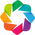

Row
    [0] HoloViews(Overlay, height=300, sizing_mode='fixed', width=600)

In [12]:
hv.extension("bokeh")
def plot_principal_angle_evolution(t, principal_angles):
    """
    Plots each principal angle as a function of time `t`.

    Parameters:
    - t: 1D array of time samples (e.g., Main.t)
    - principal_angles: List of arrays, each containing principal angles at each t
                        (e.g., Main.principal_angles — a list of 1D arrays)
    """

    # Convert list of vectors to 2D array: angles[i, j] = j-th angle at time t[i]
    angles = np.array(principal_angles)  # shape: (len(t), k)

    curves = []
    for j in range(angles.shape[1]):
        angle_values = angles[:, j]
        label        = f"θ{j+1}(t)"
        curves.append(hv.Curve((t, angle_values), 't', 'angle (degrees)').opts(
            show_grid=True,
            line_width=2,
            tools=['hover'],
            title="Principal Angle Evolution"
        ).relabel(label))

    return hv.Overlay(curves).opts( legend_position="top_left", height=300, width=600)
pn.Row(plot_principal_angle_evolution(Main.ts, Main.principal_angles))

# 3. Takeaways

- The Grassmannian $\mathrm{Gr}(k, n)$ is the space of all $k$-dimensional subspaces of $\mathbb{R}^n$.
- Local coordinates describe how subspaces vary near a point.
- Principal angles provide a natural measure of distance between subspaces.
- Geodesics trace the shortest paths between subspaces on the manifold.
- These tools lay the foundation for interpolation, optimization, and learning directly on the space of subspaces.